# Self-Organizing Maps (SOMs) Notebook
## Data extraction for composites

**Notebook by Maria J. Molina (NCAR) and Alice DuVivier (NCAR).**

This Notebook reads in data from the CESM2-LE for a user-specified variable. It subsets the data to be just around Antarctica to create composites from.

In [1]:
# Needed imports

from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

In [2]:
import dask
dask.__version__
# Did a conda update dask on cheyenne to get to 2021.09

'2021.09.1'

In [3]:
# start up dask

cluster = NCARCluster(memory='100 GB', walltime='1:00:00', cores=4, processes=2, resource_spec='select=1:ncpus=2:mem=100GB')
cluster.scale(40) # number of workers requested
#cluster.adapt(1,80) # min and max
client = Client(cluster)

cluster = NCARCluster(memory="100GB", walltime='8:00:00', cores=4, processes=2, resource_spec='select=1:ncpus=2:mem=100GB')
Each worker has 100GB, resource_spec is assigning this. 

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.23:45685,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Section 1: Load and get correct training data

In [54]:
# set some info for the CESM2-LE data
# set: variable to test, the location of the data, which ensemble member
var_in = 'V'

# U, V -- need to just grab lowest level and keep that for UBOT/VBOT

 # do not want smbb data
forcing = 'cmip6'
# only daily data
freq = 'day_1'

### Load in the data

In [55]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [56]:
cat

,unique
component,6
stream,26
case,200
member_id,100
variable,1906
start_time,157
end_time,180
time_range,163
long_name,1800
units,184


In [57]:
subset = cat.search(variable=var_in, forcing_variant=forcing, frequency=freq)

In [58]:
#subset
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,atm,cam.h6,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,V,1850-01-01,1859-12-31,18500101-18591231,Meridional wind,m/s,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
1,atm,cam.h6,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,V,1860-01-01,1869-12-31,18600101-18691231,Meridional wind,m/s,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
2,atm,cam.h6,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,V,1870-01-01,1879-12-31,18700101-18791231,Meridional wind,m/s,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
3,atm,cam.h6,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,V,1880-01-01,1889-12-31,18800101-18891231,Meridional wind,m/s,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1
4,atm,cam.h6,b.e21.BHISTcmip6.f09_g17.LE2-1001.001,r1i1001p1f1,V,1890-01-01,1899-12-31,18900101-18991231,Meridional wind,m/s,1.0,day_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,historical,cmip6,1001.001,1001,CESM2_historical_r1i1001p1f1


In [59]:
subset

,unique
component,1
stream,1
case,100
member_id,50
variable,1
start_time,26
end_time,26
time_range,26
long_name,1
units,1


In [60]:
# make arrays of half (25) of the CESM2-LE members 
# select every other from the large ensemble of both macro and micro starts
# note that the naming of the files (YYYY.#### e.g. 1001.001) doesn't match the member_id directly, 
# but the ensemble number (### e.g. 001) does match the member_id field r? directly. So use this to search

# set list of members from the dataset
member_ids = subset.df.member_id.unique()

# set list of members to KEEP
keep_list = ['r1i', 'r3i', 'r5i','r7i', 'r9i']


In [61]:
member_keep = [] # make a list to fill

for member in keep_list:
    for member_id in member_ids:
        if member in member_id:
            member_keep.append(member_id)

In [62]:
#check that we're keeping the right ones
member_keep

['r1i1001p1f1',
 'r1i1231p1f1',
 'r1i1251p1f1',
 'r1i1281p1f1',
 'r1i1301p1f1',
 'r3i1041p1f1',
 'r3i1231p1f1',
 'r3i1251p1f1',
 'r3i1281p1f1',
 'r3i1301p1f1',
 'r5i1081p1f1',
 'r5i1231p1f1',
 'r5i1251p1f1',
 'r5i1281p1f1',
 'r5i1301p1f1',
 'r7i1121p1f1',
 'r7i1231p1f1',
 'r7i1251p1f1',
 'r7i1281p1f1',
 'r7i1301p1f1',
 'r9i1161p1f1',
 'r9i1231p1f1',
 'r9i1251p1f1',
 'r9i1281p1f1',
 'r9i1301p1f1']

In [63]:
# now reduce subset based on just the members to keep
subset = subset.search(member_id=member_keep)

In [64]:
%%time
#actually load the data we selected into a dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 23.1 s, sys: 444 ms, total: 23.5 s
Wall time: 27.3 s


In [65]:
# print names of the dataset keys, which refer to each of the ensembles loaded
dsets.keys()

dict_keys(['atm.historical.cam.h6.cmip6.V', 'atm.ssp370.cam.h6.cmip6.V'])

In [66]:
# load in the historical and future datasets

historicals = []
futures = []

for key in sorted(dsets.keys()):
    if 'historical' in key:
        historicals.append(dsets[key])
        print(key)
    elif 'ssp370' in key:
        futures.append(dsets[key])
        print(key)

atm.historical.cam.h6.cmip6.V
atm.ssp370.cam.h6.cmip6.V


In [67]:
# Now put these into an array by member_id
historical_ds = xr.concat(historicals, dim='member_id')
future_ds = xr.concat(futures, dim='member_id')

In [68]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds = xr.concat([historical_ds,future_ds],dim='time')

In [69]:
ds.time

<xarray.DataArray 'time' (time: 91617)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [70]:
# look at levels
ds.lev

<xarray.DataArray 'lev' (lev: 32)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  35.92325 ,  43.19375 ,
        51.677499,  61.520498,  73.750958,  87.82123 , 103.317127, 121.547241,
       142.994039, 168.22508 , 197.908087, 232.828619, 273.910817, 322.241902,
       379.100904, 445.992574, 524.687175, 609.778695, 691.38943 , 763.404481,
       820.858369, 859.534767, 887.020249, 912.644547, 936.198398, 957.48548 ,
       976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [71]:
ds.lev.isel(lev=31)

<xarray.DataArray 'lev' ()>
array(992.55609512)
Coordinates:
    lev      float64 992.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [72]:
ds = ds.isel(lev=31)

In [73]:
ds

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, time: 91617, member_id: 25, nbnd: 2, lon: 288, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lev           float64 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 1850-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (time, member_id, zlon, nbnd) float64 dask.array<chunksize=(60226, 25, 1, 2), meta=np.ndarray>
    gw            (time, member_id, lat) float64 dask.array<chunksize=(60226, 25, 192), meta=np.ndarray>
    hyam          (time, member_id) float64 dask.array<chunksize=(60226, 25), meta=np.ndarray>
    hybm          (time, member_id) float64 dask.array<chunksize=(60226, 25), meta=np.ndarray>
    P0            (time, member_id) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (time, member_id, ilev) float64 dask.array<chunksize=(60226, 25, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(25, 240), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(25, 240), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(25, 240), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(25, 240), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(25, 240), meta=np.ndarray>
    V             (member_id, time, lat, lon) float64 dask.array<chunksize=(1, 240, 192, 288), meta=np.ndarray>
Attributes:
    topography_file:         /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/f...
    Conventions:             CF-1.0
    source:                  CAM
    case:                    b.e21.BHISTcmip6.f09_g17.LE2-1301.009
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_varname:      ['V']
    initial_file:            b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.13...
    time_period_freq:        day_1
    logname:                 sunseon
    intake_esm_dataset_key:  atm.historical.cam.h6.cmip6.V

## Section 2: Drop the lats that we don't need

In [74]:
# set some limits for Antarctica in general
lat_max = -60
lat_min = -90

In [75]:
# now drop points that are masked
ds_subset = ds.where(((ds['lat']<lat_max) & (ds['lat']>lat_min)), drop=True)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [76]:
ds_subset = ds_subset[var_in]

In [77]:
ds_subset

,Array,Chunk
Bytes,152.36 GiB,16.35 MiB
Shape,"(25, 91617, 31, 288)","(1, 240, 31, 288)"
Count,81051 Tasks,10050 Chunks
Type,float64,numpy.ndarray


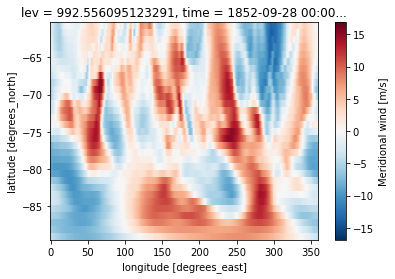

In [78]:
# check that we have all of Antarctica here
ds_subset.sel(member_id='r1i1281p1f1').isel(time=1000).plot()

In [79]:
#%%time
## actually load the data so it doesn't get too big later and makes DASK angry
#ds_subset.load()

## Section 3: Subset the times

In [80]:
ds_subset.time

<xarray.DataArray 'time' (time: 91617)>
array([cftime.DatetimeNoLeap(1850, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    lev      float64 992.6
  * time     (time) object 1850-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [81]:
# keep just years greater than 1980 and less than 2080 
yy_st = "1980"
yy_ed = "2080"
ds_subset = ds_subset.sel(time=slice(yy_st, yy_ed))

In [82]:
ds_subset.time.dt.month

<xarray.DataArray 'month' (time: 36866)>
array([ 1,  1,  1, ..., 12, 12, 12])
Coordinates:
    lev      float64 992.6
  * time     (time) object 1980-01-01 00:00:00 ... 2080-12-31 00:00:00

In [83]:
# keep just times corresponding to winter (SH: all times between april and sept)
ds_subset_winter = ds_subset.isel(time=ds_subset.time.dt.month.isin([7,8,9]))

In [84]:
ds_subset_winter

,Array,Chunk
Bytes,15.45 GiB,6.27 MiB
Shape,"(25, 9292, 31, 288)","(1, 92, 31, 288)"
Count,88901 Tasks,3800 Chunks
Type,float64,numpy.ndarray


In [85]:
%%time
# actually load the data so it doesn't get too big later and makes DASK angry
#ds_subset_winter.persist()
ds_subset_winter.load()

CPU times: user 3min 39s, sys: 30.8 s, total: 4min 10s
Wall time: 21min 23s


<xarray.DataArray 'V' (member_id: 25, time: 9292, lat: 31, lon: 288)>
array([[[[-6.17753528e+00, -6.36567353e+00, -6.55185470e+00, ...,
          -5.59114401e+00, -5.79022920e+00, -5.98578665e+00],
         [-7.71428476e+00, -7.91264993e+00, -8.10164714e+00, ...,
          -7.06745308e+00, -7.29063331e+00, -7.50622712e+00],
         [-8.25311036e+00, -8.44687168e+00, -8.62683702e+00, ...,
          -7.61436763e+00, -7.83938583e+00, -8.05195956e+00],
         ...,
         [ 3.85282548e+00,  4.21294789e+00,  3.80596197e+00, ...,
           2.91659112e+00,  3.11139651e+00,  3.39555406e+00],
         [ 3.07752804e+00,  3.37443389e+00,  3.74511135e+00, ...,
           2.34258511e+00,  2.52561093e+00,  2.80438092e+00],
         [ 2.35027801e+00,  2.61475395e+00,  2.92127241e+00, ...,
           1.19030076e+00,  1.62337173e+00,  2.03830152e+00]],

        [[-6.46640726e+00, -6.59144034e+00, -6.71399340e+00, ...,
          -6.06677631e+00, -6.20407134e+00, -6.33735484e+00],
         [-7.83203485e+00, -7.94697128e+00, -8.05212700e+00, ...,
          -7.42929242e+00, -7.57210882e+00, -7.70621362e+00],
         [-8.33094013e+00, -8.45938815e+00, -8.57599035e+00, ...,
          -7.91218686e+00, -8.06107888e+00, -8.19992649e+00],
...
         [ 7.42299361e+00,  7.20786844e+00,  7.11184833e+00, ...,
           8.03583201e+00,  7.92326359e+00,  7.67447940e+00],
         [ 7.65761115e+00,  7.05246886e+00,  6.49815662e+00, ...,
           8.58354194e+00,  8.47036287e+00,  8.15714324e+00],
         [ 8.01207337e+00,  7.34128238e+00,  6.53025065e+00, ...,
           8.76382890e+00,  8.75138989e+00,  8.51345241e+00]],

        [[-6.79343476e+00, -6.95623702e+00, -7.11619393e+00, ...,
          -6.27711318e+00, -6.45392753e+00, -6.62609415e+00],
         [-8.98653914e+00, -9.10311899e+00, -9.21043772e+00, ...,
          -8.58084002e+00, -8.72429909e+00, -8.85931359e+00],
         [-9.34738795e+00, -9.48351252e+00, -9.60856143e+00, ...,
          -8.91854912e+00, -9.06871830e+00, -9.21097618e+00],
         ...,
         [ 3.39995659e+00,  3.83018160e+00,  4.24696532e+00, ...,
           1.32575696e+00,  2.15734700e+00,  2.85931086e+00],
         [ 3.65229250e+00,  4.25669166e+00,  4.74220690e+00, ...,
           1.35402071e+00,  2.19802851e+00,  2.96095184e+00],
         [ 3.91198015e+00,  4.61004853e+00,  5.17046016e+00, ...,
           1.37167153e+00,  2.24679045e+00,  3.10267571e+00]]]])
Coordinates:
  * lat        (lat) float64 -89.06 -88.12 -87.17 ... -62.67 -61.73 -60.79
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev        float64 992.6
  * time       (time) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
  * member_id  (member_id) <U11 'r1i1001p1f1' 'r1i1231p1f1' ... 'r9i1301p1f1'
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Meridional wind
    cell_methods:  time: mean

## Section 4: Save data for making composites

In [86]:
ds_subset_winter.shape

(25, 9292, 31, 288)

In [87]:
# Flatten the times and member_id
subset_for_composites = ds_subset_winter.stack(new=("member_id","time"))

In [88]:
subset_for_composites

<xarray.DataArray 'V' (lat: 31, lon: 288, new: 232300)>
array([[[-6.17753528, -6.46640726, -6.13511184, ..., -6.76764075,
         -3.60820418, -6.79343476],
        [-6.36567353, -6.59144034, -6.27914719, ..., -6.90745928,
         -3.84544217, -6.95623702],
        [-6.5518547 , -6.7139934 , -6.42075473, ..., -7.04524228,
         -4.0816865 , -7.11619393],
        ...,
        [-5.59114401, -6.06677631, -5.67875639, ..., -6.32502267,
         -2.88617877, -6.27711318],
        [-5.7902292 , -6.20407134, -5.83494918, ..., -6.47647367,
         -3.12840368, -6.45392753],
        [-5.98578665, -6.33735484, -5.98714002, ..., -6.62408875,
         -3.36915073, -6.62609415]],

       [[-7.71428476, -7.83203485, -7.01947089, ..., -6.86912527,
         -5.03261632, -8.98653914],
        [-7.91264993, -7.94697128, -7.13626644, ..., -6.99189635,
         -5.27182846, -9.10311899],
        [-8.10164714, -8.052127  , -7.24582056, ..., -7.10862594,
         -5.50447998, -9.21043772],
...
        [ 2.34258511,  4.24885686, -3.00476383, ..., 10.06214938,
          8.58354194,  1.35402071],
        [ 2.52561093,  4.48258682, -2.53406637, ..., 10.26269811,
          8.47036287,  2.19802851],
        [ 2.80438092,  4.69513267, -1.89744962, ..., 10.60470927,
          8.15714324,  2.96095184]],

       [[ 2.35027801,  4.83913484, -1.18131204, ..., 10.31806905,
          8.01207337,  3.91198015],
        [ 2.61475395,  5.00177075, -0.37662075, ..., 10.55712062,
          7.34128238,  4.61004853],
        [ 2.92127241,  5.15912397,  0.56488317, ..., 10.77258611,
          6.53025065,  5.17046016],
        ...,
        [ 1.19030076,  4.24507991, -3.4341547 , ...,  9.99497388,
          8.7638289 ,  1.37167153],
        [ 1.62337173,  4.43829464, -2.76528485, ..., 10.03803422,
          8.75138989,  2.24679045],
        [ 2.03830152,  4.63759258, -1.97874813, ..., 10.12640993,
          8.51345241,  3.10267571]]])
Coordinates:
  * lat        (lat) float64 -89.06 -88.12 -87.17 ... -62.67 -61.73 -60.79
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev        float64 992.6
  * new        (new) MultiIndex
  - member_id  (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time       (new) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Meridional wind
    cell_methods:  time: mean

In [89]:
# assign to numpy array object
subsetarray = subset_for_composites.values

In [90]:
subsetarray.shape

(31, 288, 232300)

In [91]:
subset_for_composites

<xarray.DataArray 'V' (lat: 31, lon: 288, new: 232300)>
array([[[-6.17753528, -6.46640726, -6.13511184, ..., -6.76764075,
         -3.60820418, -6.79343476],
        [-6.36567353, -6.59144034, -6.27914719, ..., -6.90745928,
         -3.84544217, -6.95623702],
        [-6.5518547 , -6.7139934 , -6.42075473, ..., -7.04524228,
         -4.0816865 , -7.11619393],
        ...,
        [-5.59114401, -6.06677631, -5.67875639, ..., -6.32502267,
         -2.88617877, -6.27711318],
        [-5.7902292 , -6.20407134, -5.83494918, ..., -6.47647367,
         -3.12840368, -6.45392753],
        [-5.98578665, -6.33735484, -5.98714002, ..., -6.62408875,
         -3.36915073, -6.62609415]],

       [[-7.71428476, -7.83203485, -7.01947089, ..., -6.86912527,
         -5.03261632, -8.98653914],
        [-7.91264993, -7.94697128, -7.13626644, ..., -6.99189635,
         -5.27182846, -9.10311899],
        [-8.10164714, -8.052127  , -7.24582056, ..., -7.10862594,
         -5.50447998, -9.21043772],
...
        [ 2.34258511,  4.24885686, -3.00476383, ..., 10.06214938,
          8.58354194,  1.35402071],
        [ 2.52561093,  4.48258682, -2.53406637, ..., 10.26269811,
          8.47036287,  2.19802851],
        [ 2.80438092,  4.69513267, -1.89744962, ..., 10.60470927,
          8.15714324,  2.96095184]],

       [[ 2.35027801,  4.83913484, -1.18131204, ..., 10.31806905,
          8.01207337,  3.91198015],
        [ 2.61475395,  5.00177075, -0.37662075, ..., 10.55712062,
          7.34128238,  4.61004853],
        [ 2.92127241,  5.15912397,  0.56488317, ..., 10.77258611,
          6.53025065,  5.17046016],
        ...,
        [ 1.19030076,  4.24507991, -3.4341547 , ...,  9.99497388,
          8.7638289 ,  1.37167153],
        [ 1.62337173,  4.43829464, -2.76528485, ..., 10.03803422,
          8.75138989,  2.24679045],
        [ 2.03830152,  4.63759258, -1.97874813, ..., 10.12640993,
          8.51345241,  3.10267571]]])
Coordinates:
  * lat        (lat) float64 -89.06 -88.12 -87.17 ... -62.67 -61.73 -60.79
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev        float64 992.6
  * new        (new) MultiIndex
  - member_id  (new) object 'r1i1001p1f1' 'r1i1001p1f1' ... 'r9i1301p1f1'
  - time       (new) object 1980-07-01 00:00:00 ... 2080-09-30 00:00:00
Attributes:
    mdims:         1
    units:         m/s
    long_name:     Meridional wind
    cell_methods:  time: mean

## Section 5: Save data as a netcdf

In [92]:
fout = 'antarctic_data_for_som_composites_'+var_in

In [93]:
# set some info for output
longname = subset_for_composites.long_name
print(longname)
units = subset_for_composites.units
print(units)

Meridional wind
m/s


In [94]:
type(subset_for_composites.lon.values)

numpy.ndarray

In [95]:
ds_to_save = xr.Dataset({'data': (['lat','lon','training_times'], subsetarray)}, 
                        coords={'time':(['training_times'],subset_for_composites.time.values),
                                'member_id':(['training_times'],subset_for_composites.member_id.values),
                                'lon':(['lon'],subset_for_composites.lon.values),
                                'lat':(['lat'],subset_for_composites.lat.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [96]:
ds_to_save

<xarray.Dataset>
Dimensions:    (lat: 31, lon: 288, training_times: 232300)
Coordinates:
    time       (training_times) object 1980-07-01 00:00:00 ... 2080-09-30 00:...
    member_id  (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -89.06 -88.12 -87.17 ... -62.67 -61.73 -60.79
Dimensions without coordinates: training_times
Data variables:
    data       (lat, lon, training_times) float64 -6.178 -6.466 ... 8.513 3.103
Attributes:
    Author:    Alice DuVivier
    units:     m/s
    longname:  Meridional wind

In [97]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file